************* 1 *************
************* 2 *************
************* 3 *************
************* 4 *************
************* 5 *************
************* 6 *************
************* 7 *************
************* 8 *************
************* 9 *************
************* 10 *************
************* 11 *************
************* 12 *************
************* 13 *************
************* 14 *************
************* 15 *************
************* 16 *************
************* 17 *************
Line hi nahi hai bc
************* 18 *************
Line hi nahi hai bc
************* 19 *************
Line hi nahi hai bc
************* 20 *************
************* 21 *************
************* 22 *************
************* 23 *************
Line hi nahi hai bc
************* 24 *************
Line hi nahi hai bc
************* 25 *************
************* 26 *************
Line hi nahi hai bc
************* 27 *************
Line hi nahi hai bc
************* 28 *************
*

************* 247 *************
************* 248 *************
************* 249 *************
************* 250 *************
************* 251 *************
************* 252 *************
************* 253 *************
************* 254 *************
************* 255 *************
************* 256 *************
************* 257 *************
************* 258 *************
************* 259 *************
************* 260 *************
************* 261 *************
************* 262 *************
************* 263 *************
************* 264 *************
************* 265 *************
************* 266 *************
************* 267 *************
************* 268 *************
************* 269 *************
************* 270 *************
************* 271 *************
************* 272 *************
************* 273 *************
************* 274 *************
************* 275 *************
************* 276 *************
************* 277 *************
********

error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\imgproc\src\color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


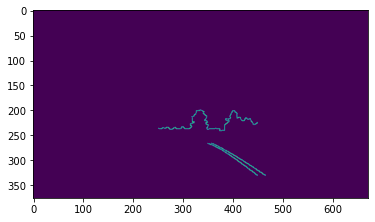

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def do_canny(frame):
    # Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
    gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
    # Applies a 5x5 gaussian blur with deviation of 0 to frame - not mandatory since Canny will do this for us
    blur = cv.GaussianBlur(gray, (3, 3), 0)
    # Applies Canny edge detector with minVal of 50 and maxVal of 150
    canny = cv.Canny(blur, 50, 150)
    return canny

def do_segment(frame):
    # Since an image is a multi-directional array containing the relative intensities of each pixel in the image, we can use frame.shape to return a tuple: [number of rows, number of columns, number of channels] of the dimensions of the frame
    # frame.shape[0] give us the number of rows of pixels the frame has. Since height begins from 0 at the top, the y-coordinate of the bottom of the frame is its height
    height = frame.shape[0]
    #print(frame.shape)
    # Creates a triangular polygon for the mask defined by three (x, y)
    #coordinates (376, 672)
    polygons = np.array([
                            [(150, 330), (600, 330),(400,190), (300, 190)]
                        ])
    mask = np.zeros_like(frame)
    cv.fillPoly(mask, polygons, 255)
    # Bitwise operation between canny image and mask image
    masked_image = cv.bitwise_and(frame, mask)
    return masked_image

def calculate_lines(frame, lines, left_line_previous, right_line_previous):
    # Empty arrays to store the coordinates of the left and right lines
    left = []
    right = []
    #print(lines)
    # Loops through every detected line
    for line in lines:
        # Reshapes line from 2D array to 1D array
        x1, y1, x2, y2 = line.reshape(4)
        # Fits a linear polynomial to the x and y coordinates and returns a vector of coefficients which describe the slope and y-intercept
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        y_intercept = parameters[1]
        # If slope is negative, the line is to the left of the lane, and otherwise, the line is to the right of the lane
        if slope < 0:
            left.append((slope, y_intercept))
        else:
            right.append((slope, y_intercept))
            
    if len(left) == 0:
        left_line = left_line_previous
    else:
        left_avg = np.average(left, axis = 0)
        left_line = calculate_coordinates(frame, left_avg)
    if len(right) == 0:
        right_line = right_line_previous
    else:
        right_avg = np.average(right, axis = 0)
        right_line = calculate_coordinates(frame, right_avg)
        
    return left_line, right_line

def calculate_coordinates(frame, parameters):
    slope, intercept = parameters
    # Sets initial y-coordinate as height from top down (bottom of the frame)
    y1 = frame.shape[0]
    # Sets final y-coordinate as 150 above the bottom of the frame
    y2 = int(y1 - 150)
    # Sets initial x-coordinate as (y1 - b) / m since y1 = mx1 + b
    x1 = int((y1 - intercept) / slope)
    # Sets final x-coordinate as (y2 - b) / m since y2 = mx2 + b
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

def visualize_lines(frame, lines):
    # Creates an image filled with zero intensities with the same dimensions as the frame
    lines_visualize = np.zeros_like(frame)
    # Checks if any lines are detected
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            # Draws lines between two coordinates with green color and 5 thickness
            cv.line(lines_visualize, (x1, y1), (x2, y2), (0, 255, 0), 5)
    return lines_visualize

# The video feed is read in as a VideoCapture object
cap = cv.VideoCapture(r"Lab 1 Data_Trim.mp4")
left_line_previous = None
right_line_previous = None
i = 0
while (cap.isOpened()):
    i+= 1
    print("*************", i, "*************")
    # ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
    ret, frame = cap.read()
    canny = do_canny(frame)
    #cv.imshow("canny", canny)
    #plt.imshow(frame)
    #plt.imshow(canny)
    segment = do_segment(canny)
    #plt.imshow(segment)
    hough = cv.HoughLinesP(segment, 7, np.pi / 180, 100, np.array([]), minLineLength = 40, maxLineGap = 5)
    if hough is not None:

        # Averages multiple detected lines from hough into one line for left border of lane and one line for right border of lane
        left_line, right_line = calculate_lines(frame, hough, left_line_previous, right_line_previous)
        left_line_previous = left_line
        right_line_previous = right_line
        # Visualizes the lines
        lines_visualize = visualize_lines(frame, np.array([left_line, right_line]))

        # Overlays lines on frame by taking their weighted sums and adding an arbitrary scalar value of 1 as the gamma argument
        output = cv.addWeighted(frame, 0.9, lines_visualize, 1, 1)
        cv.imshow("Lane Detection", output)
        # Opens a new window and displays the output frame
        # Frames are read by intervals of 10 milliseconds. The programs breaks out of the while loop when the user presses the 'q' key
        if cv.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        print("Line hi nahi hai bc")
# The following frees up resources and closes all windows
cap.release()
cv.destroyAllWindows()